# Mini projekt 3
Jan Jędrzejewski, Dominik Łopatecki

In [4]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
torch.cuda.set_device(0)
device = torch.device("cuda")
device

device(type='cuda')

In [ ]:
!unzip train.zip

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

trainset = ImageFolder("train/", transform=transform)
train_data, validate_data = train_test_split(trainset, test_size=0.2, random_state=42)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validate_loader = torch.utils.data.DataLoader(validate_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

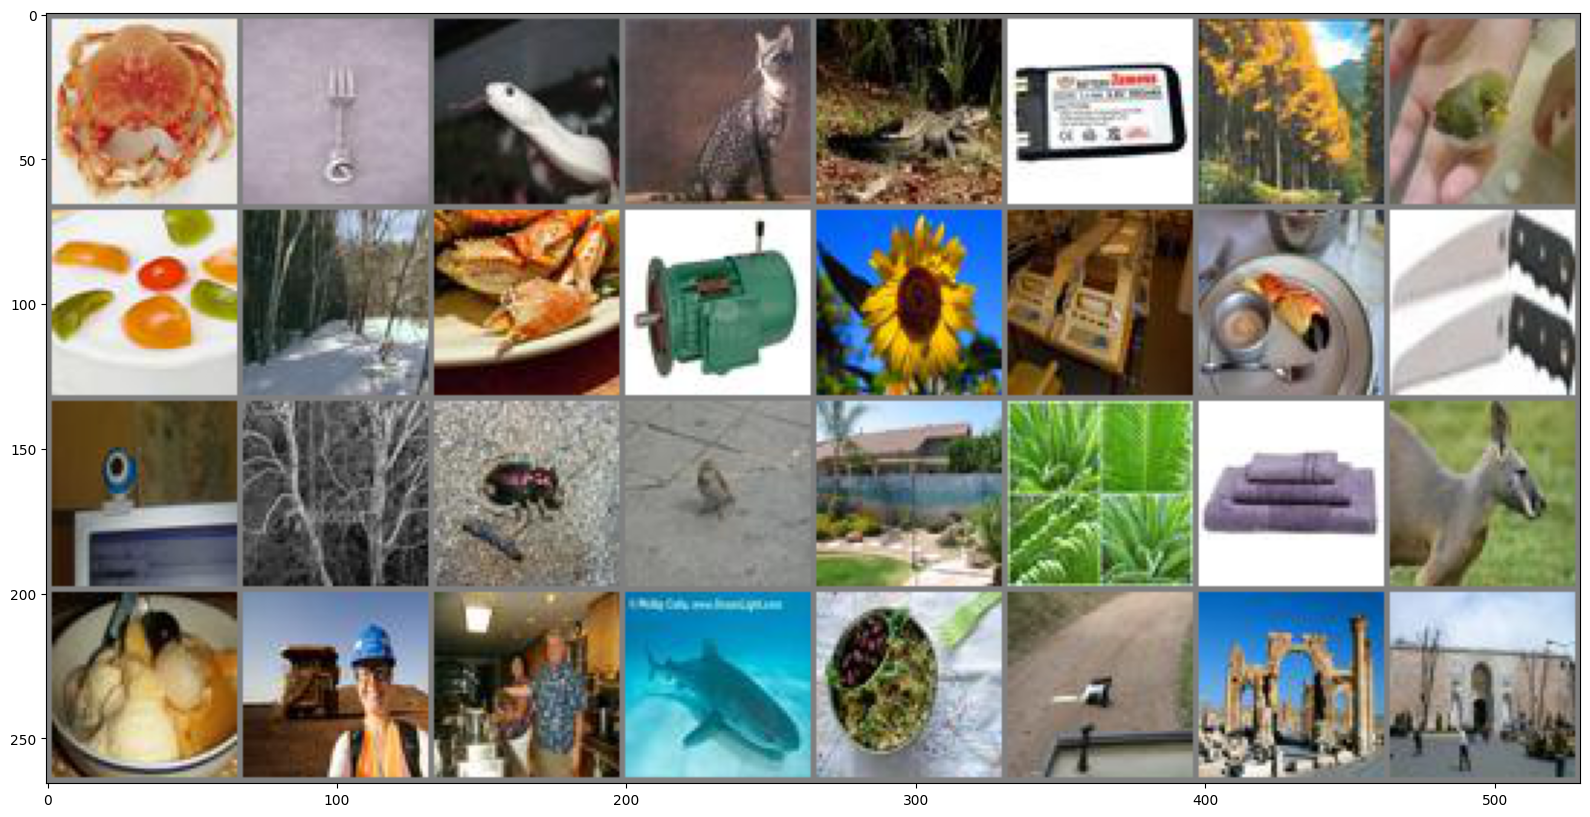

 crab spoon snake   cat crocodilian battery birch  bird icecream birch  crab motor flower printer  crab   saw camera birch beetle  bird antenna  palm towel kangaroo icecream truck  crab  fish  bean monkey memorial memorial


In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))

In [16]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

# Model sieci

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna 1 - obrazy 64x64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        ## Warstwa konwolucyjna 2 - obrazy 30x30
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        ## Warstwa konwolucyjna 3 - obrazy 13x13
        self.conv3 = nn.Conv2d(16, 16, 5)
        self.pool3 = nn.MaxPool2d(2)
        ## Warstwa liniowa - obrazy 4x4
        self.fc1 = nn.Linear(16 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
)

# Trening

In [18]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
      for images, labels in data_loader:
          images, labels = images.to(device), labels.to(device)
          output = model(images)
          _, preds = torch.max(output, dim=1)
          correct += torch.sum(preds==labels).item()
          total += labels.size(0)
    return correct / total

def train(model, optimizer, loss_module, loader, loader_test, num_epochs):
    iters, Loss, train_acc, val_acc = [], [], [], []
    model.train()

    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_losses = []
        print(epoch)
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_module(outputs, labels)
            loss.backward()
            epoch_losses.append(loss.item())
            
            optimizer.step()

        iters.append(epoch)
        Loss.append(np.array(epoch_losses).mean())
        train_acc.append(get_accuracy(model, loader))
        if loader_test:
            val_acc.append(get_accuracy(model, loader_test))
        else:
            val_acc.append(0)

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(iters, Loss)
    plt.title("loss")

    plt.subplot(1,2,2)
    plt.title("training curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print(f"Final train accuracy: {round(train_acc[-1]*100, 2)}%")
    #print(f"Final validation accuracy: {round(val_acc[-1]*100, 2)}%")

  0%|          | 0/20 [00:00<?, ?it/s]

0


  5%|▌         | 1/20 [02:05<39:53, 125.99s/it]

1


 10%|█         | 2/20 [03:45<33:02, 110.12s/it]

2


 15%|█▌        | 3/20 [05:28<30:20, 107.09s/it]

3


 20%|██        | 4/20 [07:08<27:46, 104.14s/it]

4


 25%|██▌       | 5/20 [08:50<25:55, 103.67s/it]

5


 30%|███       | 6/20 [10:31<23:55, 102.52s/it]

6


 35%|███▌      | 7/20 [12:12<22:05, 101.99s/it]

7


 40%|████      | 8/20 [13:59<20:46, 103.85s/it]

8


 45%|████▌     | 9/20 [15:42<18:57, 103.39s/it]

9


 50%|█████     | 10/20 [17:25<17:13, 103.33s/it]

10


 55%|█████▌    | 11/20 [19:07<15:27, 103.02s/it]

11


 60%|██████    | 12/20 [20:47<13:35, 101.88s/it]

12


 65%|██████▌   | 13/20 [22:27<11:49, 101.34s/it]

13


 70%|███████   | 14/20 [24:07<10:05, 100.99s/it]

14


 75%|███████▌  | 15/20 [25:46<08:21, 100.29s/it]

15


 80%|████████  | 16/20 [27:27<06:42, 100.61s/it]

16


 85%|████████▌ | 17/20 [29:08<05:01, 100.62s/it]

17


 90%|█████████ | 18/20 [30:48<03:21, 100.59s/it]

18


 95%|█████████▌| 19/20 [32:27<01:40, 100.17s/it]

19


100%|██████████| 20/20 [34:07<00:00, 102.36s/it]


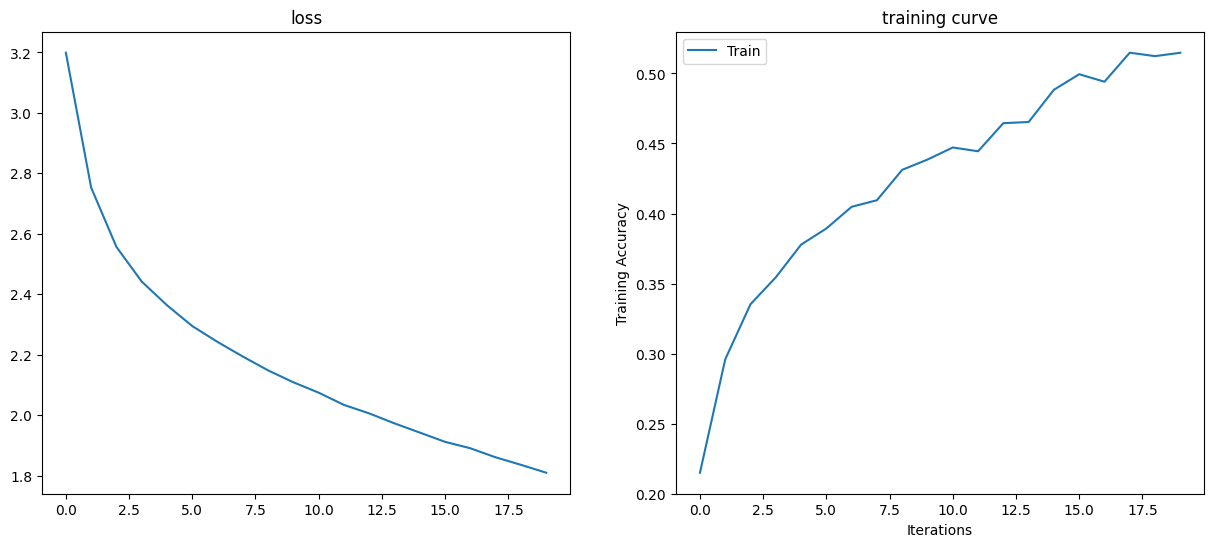

Final train accuracy: 51.48%


In [19]:
Loss_module = nn.CrossEntropyLoss()
Optimizer = optim.Adam(net.parameters(), lr=0.001)

train(net, Optimizer, Loss_module, trainloader, None, num_epochs=20)

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in trainset.classes}
total_pred = {classname: 0 for classname in trainset.classes}

# again no gradients needed
with torch.no_grad():
    for data in validate_loader:
        images, labels = data
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[trainset.classes[label]] += 1
            total_pred[trainset.classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

# Finalny model

In [82]:
!unzip test_all.zip

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

testset = ImageFolder("test_all/", transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

In [88]:
from os import listdir
files = listdir("train/test_all/")
PREDS = []

with torch.no_grad():
    i = 0
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        for pred in predictions:
            PREDS.append((files[i], int(pred)))
            i += 1


In [91]:
df = pd.DataFrame(PREDS)
df.to_csv("piatek_Jedrzejewski_Lopatecki.csv", index=False, header=None)
